(SequentialModeling)=
# Sequential models and representation learning

In credit card fraud detection, the choice of features is crucial for accurate classification. Considerable research effort has been dedicated to the development of features that are relevant to characterize fraudulent patterns. Feature engineering strategies based on feature aggregations have become commonly adopted {cite}`bahnsen2016feature`. Feature aggregation establishes a connection between the current transaction and other related transactions by computing statistics over their variables. They often originate from complex rules defined from human expertise, and many experiments report that they significantly improve detection {cite}`dal2014learned,jurgovsky2018sequence,dastidar2020nag`.

Using feature aggregation for fraud detection is part of a research topic referred to as "context-aware fraud detection", where one considers the context (e.g. the cardholder history) associated with a transaction to make the decision. This allows, for instance, to give insights into the properties of the transaction relative to the usual purchase patterns of the cardholder and/or terminal, which is intuitively a relevant piece of information. 

## Context-aware fraud detection

The context is established based on a landmark variable, which is in most of the cases the Customer ID. Concretely, one starts by building the sequence of historical transactions, chronologically ordered from the oldest to the current one, that have the same value for the landmark variable as the current transaction. 

![Building the transaction sequence](./images/transaction_sequence.png)


This whole sequence is the raw basis for context-aware approaches. Indeed, the general process relies on the construction of new features or representations for each given transaction based on its contextual sequence. However, approaches can be divided into two broad categories, the first (Expert representations) relying on domain knowledge from experts to create rules and build feature aggregation, and the second (Automatic representations) oriented towards automated feature extraction strategies with deep learning models. 

### Expert representations

To build expert features from the base sequence, a selection layer relying on expert constraints (same Merchant Category code, same Country, more recent than a week, etc.) is first applied to obtain a more specific subsequence. Then, an aggregation function (sum, avg, ...) is computed over the values of a chosen feature (e.g. amount) in the subsequence. For more details, {cite}`bahnsen2016feature` provides a formal definition of such feature aggregations. Expert features are not necessarily transferable in any fraud detection domain since they rely on specific features that might not always be available. Nevertheless, in practice, the landmark features, constraints features, and aggregated features are often chosen from a set of frequent attributes, comprising Time, Amount, Country, Merchant Category, Customer ID, transaction type.

![Expert features creation](./images/expert_agg.png)


### Automatic representations

The other family of context-aware approaches considers the sequence directly as input in a model and lets it automatically learn the right connections to optimize fraud detection. The advantage of not relying on human knowledge to build the relevant features is obviously to save the costly resources and to ease adaptability and maintenance. Moreover, models can be pushed towards large architectures and learn very complex variable relationships automatically from data. However, it requires a sufficiently large dataset to properly identify the relevant patterns. Otherwise, the feature representations are not very accurate or useful. 

A baseline technique for automatic usage of contextual data would be to exploit the transaction sequence in its entirety (e.g. flattening it into a set of features), but this removes the information about the order and could lead to a very high dimensional feature space. A more popular strategy consists of (1) turning the sequences into fixed-size sequences and (2) using a special family of models that are able to deal with sequences naturally and summarizing them into relevant vector representations for fraud classification. 

This strategy is often referred to as sequential learning, the study of learning algorithms for sequential data. The sequential dependency between data points is learned at the algorithmic level. This includes sliding window methods, which often tend to ignore the order between data points within the window, but also models that are designed explicitly to consider the sequential order between consecutive data points (e.g. a Markov Chain). Such models can be found in the family of deep learning architectures under the *recurrent neural networks* category. The link between consecutive elements of the sequence is embedded in the design of the recurrent architecture, where the computation of the hidden state/layer of a more recent event depends on hidden states of previous events. 

![Illustration of a recurrent model](./images/recurrent_model.png)


Sliding window methods include architectures like 1D *convolutional neural networks* (1D-CNN), and sequential methods include architectures like the *long short-term memory* (LSTM). Such architectures have proven to be very efficient in the context of fraud detection in the past {cite}`jurgovsky2018sequence`. 

In this section, the goal is to explore automatic representation learning from cardholders' sequences of transactions and its application in context-aware fraud detection. The content starts with the practical aspects of building the pipeline to manage sequential data. Then, three architectures are successively explored: a 1D-CNN, an LSTM, and a more complex model that uses an LSTM with *Attention* {cite}`bahdanau2014neural`. The section concludes on perspectives of other modeling possibilities such as sequence-to-sequence autoencoders {cite}`sutskever2014sequence,alazizi2020dual`, or other combinations of the explored models. 

## Data processing

With sequence modeling, the building of the data processing pipeline has special importance. In particular, as explained in the introduction, its role is to create the input sequences for the sequential models to learn the representations. 

The most popular landmark variable to establish the sequence is the Customer ID. Indeed, by the very definition of credit card fraud being a payment done by someone other than the cardholder, it makes the most sense to look at the history of the customer in order to determine when a card payment is fraudulent. 

Therefore, the goal here is to establish `Datasets` and `DataLoaders` that provide, given a transaction index in the dataset, the sequence of previous transactions (including the one referred by the index) from the same cardholder. Moreover, since models usually deal with fixed-sized sequences, the sequence length will be a parameter, and sequences that are too long (resp. too short) will be cut (resp. padded).

As usual, let us start by loading a fixed training and validation period from the processed dataset.

In [1]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   537k      0 --:--:-- --:--:-- --:--:--  532k


In [2]:
DIR_INPUT='simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: user 311 ms, sys: 237 ms, total: 548 ms
Wall time: 570 ms
919767 transactions loaded, containing 8195 fraudulent transactions


In [3]:
# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7


delta_valid = delta_test

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

# By default, scales input data
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)

In [4]:
input_features

['TX_AMOUNT',
 'TX_DURING_WEEKEND',
 'TX_DURING_NIGHT',
 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
 'TERMINAL_ID_RISK_1DAY_WINDOW',
 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
 'TERMINAL_ID_RISK_7DAY_WINDOW',
 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
 'TERMINAL_ID_RISK_30DAY_WINDOW']

This time, additionally to the above features, building the sequences will require two additional fields from the DataFrames:
* `CUSTOMER_ID`: the landmark variable that will be used to select past transactions.
* `TX_DATETIME`: the time variable that will allow building sequences in chronological order.

In [5]:
dates = train_df['TX_DATETIME'].values

In [6]:
customer_ids = train_df['CUSTOMER_ID'].values

There are multiple ways to implement sequence creation for training/validation. One way is to precompute, for each transaction, the indices of the previous transactions of the sequence and to store them. Then, to build the sequences of features on the fly from the indices. 

Here we propose some steps to proceed but keep in mind that other solutions are just as valid.

### Setting the sequence length

The first step is to set a sequence length. In the literature, 5 or 10 are two values that are often chosen {cite}`jurgovsky2018sequence`. This can later be a parameter to tune but here, let us arbitrarily set it to 5 to begin with. 

In [7]:
seq_len = 5

### Ordering elements chronologically

In our case, transactions are already sorted, but in the most general case, to build the sequences, it is necessary to sort all transactions chronologically and keep the sorting indices:

In [8]:
indices_sort = np.argsort(dates)
sorted_dates = dates[indices_sort]
sorted_ids = customer_ids[indices_sort]

### Separating data according to the landmark variable (Customer ID)

After sorting, the dataset is a large sequence with all transactions from all cardholders. We can separate it into several sequences that each contain only the transactions of a single cardholder. Finally, each customer sequence can be turned into several fixed-size sequences using a sliding window and padding. 

To separate the dataset, let us get the list of customers:

In [9]:
unique_customer_ids = np.unique(sorted_ids)

In [10]:
unique_customer_ids[0:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

For each customer, the associated subsequence can be selected with a boolean mask. Here is for example the sequence of transaction IDs for customer `0`.

In [11]:
idx = 0
current_customer_id = unique_customer_ids[idx]
customer_mask = sorted_ids == current_customer_id
# this is the full sequence of transaction indices (after sort) for customer 0
customer_full_seq = np.where(customer_mask)[0]
# this is the full sequence of transaction indices (before sort) for customer 0
customer_full_seq_original_indices = indices_sort[customer_full_seq]
customer_full_seq_original_indices

array([ 1888, 10080, 12847, 15627, 18908, 22842, 37972, 42529, 44495,
       48980, 58692, 63977])

### Turning a customer sequence into fixed size sequences

The above sequence is the whole sequence for customer `0`. But the goal is to have, for each transaction `i` of this sequence, a fixed size sequence that ends with transaction `i`, which will be used as input in the sequential model to predict the label of transaction `i`. In the example above:
* For transaction 1888: the 4 previous transactions are [none,none,none,none] (Note: none can be replaced with a default value like -1). So the sequence [none, none, none, none, 1888] will be created.
* For transaction 10080, the sequence will be [none, none, none, 1888, 10080]
* ...
* For transaction 37972, the sequence will be [12847, 15627, 18908, 22842, 37972]
* Etc.

Using a sliding window (or rolling window) allows to obtain those sequences:

In [12]:
def rolling_window(array, window):
    a = np.concatenate([np.ones((window-1,))*-1,array])
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides).astype(int)

In [13]:
customer_all_seqs = rolling_window(customer_full_seq_original_indices,seq_len)

In [14]:
customer_all_seqs

array([[   -1,    -1,    -1,    -1,  1888],
       [   -1,    -1,    -1,  1888, 10080],
       [   -1,    -1,  1888, 10080, 12847],
       [   -1,  1888, 10080, 12847, 15627],
       [ 1888, 10080, 12847, 15627, 18908],
       [10080, 12847, 15627, 18908, 22842],
       [12847, 15627, 18908, 22842, 37972],
       [15627, 18908, 22842, 37972, 42529],
       [18908, 22842, 37972, 42529, 44495],
       [22842, 37972, 42529, 44495, 48980],
       [37972, 42529, 44495, 48980, 58692],
       [42529, 44495, 48980, 58692, 63977]])

### Generating the sequences of transaction features on the fly from the sequences of indices

From the indices' sequences and the features of each transaction (available in `x_train`), building the features sequences is straightforward. Let us do it for the 6th sequence:

In [15]:
customer_all_seqs[5]

array([10080, 12847, 15627, 18908, 22842])

In [16]:
x_train = torch.FloatTensor(train_df[input_features].values)

In [17]:
sixth_sequence = x_train[customer_all_seqs[5],:]

In [18]:
sixth_sequence

tensor([[ 0.6965, -0.6306,  2.1808, -0.8466,  0.0336, -1.1665,  0.0176, -0.9341,
          0.2310, -0.9810, -0.0816, -0.3445, -0.1231, -0.2491, -0.1436],
        [ 0.0358, -0.6306, -0.4586, -0.8466,  0.4450, -1.1665,  0.1112, -0.8994,
          0.2278,  0.0028, -0.0816,  0.6425, -0.1231, -0.0082, -0.1436],
        [ 1.1437, -0.6306, -0.4586, -0.3003,  0.7595, -1.0352,  0.2462, -0.8994,
          0.2458,  1.9702, -0.0816,  1.3005, -0.1231,  1.7989, -0.1436],
        [ 0.3645, -0.6306, -0.4586,  0.2461,  0.6804, -1.0352,  0.3186, -0.8647,
          0.2514,  1.9702, -0.0816,  0.3135, -0.1231, -0.8514, -0.1436],
        [ 0.3348, -0.6306, -0.4586, -0.3003,  0.7462, -1.1665,  0.2494, -0.8994,
          0.2262, -0.9810, -0.0816, -2.3185, -0.1231, -1.5743, -0.1436]])

In [19]:
sixth_sequence.shape

torch.Size([5, 15])

Note: Here, the sequence of indices (`customer_all_seqs[5]`) was made of valid indices. When there are invalid indices (`-1`), the idea is to put a "padding transaction" (e.g. with all features equal to zero or equal to the average value that they have in the training set) in the final sequence. To obtain a homogeneous code that can be used for both valid and invalid indices, on can append the "padding transaction" to `x_train` at the end and replace all `-1` with the index of this added transaction.

### Efficient implementation with pandas and groupby

The above steps are described for educational purposes as they allow to understand all the necessary operations to build the sequences of transactions. In practice, because this process requires a time-consuming loop over all Customer IDs, it is better to rely on a dataframe instead and use the pandas `groupby` function. More precisely, the idea is to group the elements of the transaction dataframe by Customer ID and to use the `shift` function to determine, for each transaction, the ones that occurred before. In order not to edit the original dataframe, let us first create a new one that only contains the necessary features.

In [20]:
df_ids_dates = pd.DataFrame({'CUSTOMER_ID': customer_ids,
        'TX_DATETIME': dates})

#checking if the transaction are chronologically ordered
datetime_diff = (df_ids_dates["TX_DATETIME"] - df_ids_dates["TX_DATETIME"].shift(1)).iloc[1:].dt.total_seconds()
assert (datetime_diff >= 0).all()

Let us now add a new column with the initial row indices, that will be later used with the `shift` function.

In [21]:
df_ids_dates["tmp_index"]  = np.arange(len(df_ids_dates))

In [22]:
df_ids_dates.head()

,CUSTOMER_ID,TX_DATETIME,tmp_index
0,579,2018-07-11 00:00:54,0
1,181,2018-07-11 00:01:59,1
2,4386,2018-07-11 00:03:39,2
3,4599,2018-07-11 00:05:50,3
4,4784,2018-07-11 00:06:04,4


The next step is to group the elements by Customer ID:

In [23]:
df_groupby_customer_id = df_ids_dates.groupby("CUSTOMER_ID")

Now it is possible to compute a shifted `tmp_index` with respect to the grouping by `CUSTOMER_ID`. For instance, shifting by 0 gives the current transaction index and shifting by 1 gives the previous transaction index (or NaN if the current transaction is the first transaction of the customer).

In [24]:
df_groupby_customer_id["tmp_index"].shift(0)

0            0
1            1
2            2
3            3
4            4
         ...  
66923    66923
66924    66924
66925    66925
66926    66926
66927    66927
Name: tmp_index, Length: 66928, dtype: int64

In [25]:
df_groupby_customer_id["tmp_index"].shift(1)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
66923    66805.0
66924    64441.0
66925    66777.0
66926    63338.0
66927    60393.0
Name: tmp_index, Length: 66928, dtype: float64

To obtain the whole sequences of indices, the only thing to do is to loop over the shift parameter, from `seq_len` - 1 to 0. 

In [26]:
sequence_indices = pd.DataFrame(
            {
                "tx_{}".format(n): df_groupby_customer_id["tmp_index"].shift(seq_len - n - 1)
                for n in range(seq_len)
            }
        )

sequence_indices = sequence_indices.fillna(-1).astype(int)

In [27]:
sequence_indices.head()

,tx_0,tx_1,tx_2,tx_3,tx_4
0,-1,-1,-1,-1,0
1,-1,-1,-1,-1,1
2,-1,-1,-1,-1,2
3,-1,-1,-1,-1,3
4,-1,-1,-1,-1,4


As a sanity check, let us see if this method computes the same sequences as the previous method for transaction 12847, 15627 and 18908 which were (see 4.2.4):

* [   -1,    -1,  1888, 10080, 12847]
* [   -1,  1888, 10080, 12847, 15627]
* [ 1888, 10080, 12847, 15627, 18908]

In [28]:
print(sequence_indices.loc[12847].values)
print(sequence_indices.loc[15627].values)
print(sequence_indices.loc[18908].values)

[   -1    -1  1888 10080 12847]
[   -1  1888 10080 12847 15627]
[ 1888 10080 12847 15627 18908]


### Managing sequence creation into a torch Dataset

Now that the process is ready and tested, the final step is to implement it within a torch `Dataset` to use it in a training loop. To simplify the usage, let us consider the "zeros" padding strategy as default. The precomputation of indices and the creation of the padding transaction (a transaction with all features to zero) will be done at initialization. Then, the `__getitem__` function will build the sequence of features on the fly. 

In [29]:
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cuda


In [30]:
class FraudSequenceDataset(torch.utils.data.Dataset):
    
    def __init__(self, x,y,customer_ids, dates, seq_len, padding_mode = 'zeros', output=True):
        'Initialization'
        
        # x,y,customer_ids, and dates must have the same length
        
        # storing the features x in self.features and adding the "padding" transaction at the end
        if padding_mode == "mean":
            self.features = torch.vstack([x, x.mean(axis=0)])
        elif padding_mode == "zeros":
            self.features = torch.vstack([x, torch.zeros(x[0,:].shape)])            
        else:
            raise ValueError('padding_mode must be "mean" or "zeros"')
        self.y = y
        self.customer_ids = customer_ids
        self.dates = dates
        self.seq_len = seq_len
        self.output = output
        
        #===== computing sequences ids =====  
        
        
        df_ids_dates = pd.DataFrame({'CUSTOMER_ID':customer_ids,
        'TX_DATETIME':dates})
        
        df_ids_dates["tmp_index"]  = np.arange(len(df_ids_dates))
        df_groupby_customer_id = df_ids_dates.groupby("CUSTOMER_ID")
        sequence_indices = pd.DataFrame(
            {
                "tx_{}".format(n): df_groupby_customer_id["tmp_index"].shift(seq_len - n - 1)
                for n in range(seq_len)
            }
        )
        
        #replaces -1 (padding) with the index of the padding transaction (last index of self.features)
        self.sequences_ids = sequence_indices.fillna(len(self.features) - 1).values.astype(int)              


    def __len__(self):
        'Denotes the total number of samples'
        # not len(self.features) because of the added padding transaction
        return len(self.customer_ids)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        
        tx_ids = self.sequences_ids[index]
        
        if self.output:
            #transposing because the CNN considers the channel dimension before the sequence dimension
            return self.features[tx_ids,:].transpose(0,1).to(DEVICE), self.y[index].to(DEVICE)
        else:
            return self.features[tx_ids,:].transpose(0,1).to(DEVICE)

As a sanity check, let us try the `Dataset` within a `DataLoader`

In [31]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_valid = torch.FloatTensor(valid_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_valid = torch.FloatTensor(valid_df[output_feature].values)

In [32]:
SEED = 42
seed_everything(SEED)

In [33]:
train_loader_params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 0}


# Generators

training_set = FraudSequenceDataset(x_train, y_train,train_df['CUSTOMER_ID'].values, train_df['TX_DATETIME'].values,seq_len,padding_mode = "zeros")
training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)

Let us see how the first training batch looks like:

In [34]:
x_batch, y_batch = next(iter(training_generator))

In [35]:
x_batch.shape

torch.Size([64, 15, 5])

In [36]:
y_batch.shape

torch.Size([64])

The shape of `x_batch` is (`batch_size`= 64,`number of features`= 15, `seq_len`= 5) which is the expected input for a 1-D convolutional network or a recurrent model like an LSTM.

## Convolutional neural network for fraud detection

Convolutional neural networks (CNN) are neural networks with specific convolutional layers that allow (1) detecting specific patterns or shapes in patches of input and (2) reducing spatial complexity when dealing with large inputs (e.g. an image with millions of pixels). 

To do that, they replace the regular fully connected layer with a layer of convolutional filters that performs a convolution operation over the input neurons. 

![Illustration of a 2D-convolutional layer](./images/convnet.png)

A convolutional layer has `num_filters` filters, with weights of a chosen dimension. If we consider a 2D-convolutional layer, each filter has 2 dimensions (width and height). In the example above, we consider an 8x6 input and a 3x3 filter. The convolution operation consists in sliding the filter over the input from left to right and from up to bottom, and each time computing the weighted sum of the input patch using the filter weights and applying an activation function to obtain an output similar to a regular neuron. In the figure, we represent with dashed squares on the left the first two input patches that the filter goes through and on the right the two corresponding outputs. Here we considered a `stride` parameter of 1, which means that the filter slides by 1 input each time. There is no padding, so the filter does not slide outside of the input, therefore the result is a map of features of dimension (8-(3-1))x(6-(3-1)), i.e. 6x4. But one can apply padding (considering that values outside the input are zeros) so that the output feature map has the same dimension as the input. 

The convolution operation can be seen as a filter scanning the input to identify a specific pattern. The weights of the filters are learned by the model. Having multiple filters allows capturing multiple patterns that are useful to reduce the loss for the task at hand. 

In order to summarize the information in final layers or to save memory in intermediate ones, the obtained feature maps can be aggregated into smaller maps with pooling layers (average, max).

### 1D-convolutions 

Note: Although not represented in the figure, if the input is an image, the input is in fact 3-dimensional (a 2D map of 3 features also called channels, namely RGB levels). The user only defines 2 dimensions for the filter (along the "sliding" directions) but the filters are in reality 3-dimensional as well, the last dimension matching the channel dimension.

2D-convolutions are only used to analyze inputs for which it makes sense to slide along 2 dimensions. In our case, to deal with transaction sequences, it only makes sense to slide along the sequence axis. Therefore, for fraud detection, we resort to 1D-convolutions and define a single filter dimension (with length equal to the number of consecutive sequence elements on which the filter looks for patterns).

### Stacking convolutional layers

One can stack convolution layers just like fully connected layers. For instance, let us consider an input transaction sequence with 5 transactions and 15 features for each transaction. If one defines a convolutional neural network with a first 1D-convolutional layer with 100 filters of length 2 and a second convolutional layer with 50 filters of length 2. Without padding, the successive features map's dimension will be the following:
* The input dimension is (5,15): 5 is the sequence length and 15 is the number of channels.
* The output dimension of the first convolutional layer is (4,100): each filter of dimension (2,15) will output a 1D feature map with 5-(2-1) = 4 features.
* The output dimension of the second convolutional layer is (3,50): each filter of dimension (2,100) will output a 1D feature map with 4-(2-1) = 3 features.

With padding, we can make sure that the sequence length does not change and obtain the dimensions (5,100) and (5,50) instead of (4,100) and (3,50). 

### Classification with a convolutional neural network

Convolutional layers produce high-level features that detect the presence of patterns or combinations of patterns within the input. These features can be considered as automatic feature aggregates and can then be used in a final regular fully connected layer for classification, after a flattening operation. This operation can be done using a pooling operator along the sequence dimension or with a flattening operator that simply concatenates the channels of all elements of the sequence into a single global vector. 

### Implementation

Convolutional layers are defined like regular layers. Instead of using the `torch.nn.Linear` module, one uses the specific layers for convolutional neural networks:

* `torch.nn.Conv1d`: this module defines a convolutional layer. The parameters are the number of input channels, the number of filters, and the dimension of the filters. 
* `torch.nn.ConstantPad1d`: this module allows us to pad a sequence with a constant value (e.g. 0) to obtain the desired sequence length after the subsequent convolutional layer.
* `torch.nn.MaxPool1d` or `AvgPool1d`: these modules perform a pooling operation over the sequence dimension. 

Let us define a `FraudConvNet` module that makes use of the above `torch` modules to take as input a sequence of `seq_len` transactions with `len(input_features)` features and predict if the last transaction is fraudulent. We will consider 2 padded convolutional layers, a max-pooling layer, a hidden fully connected layer, and an output fully connected layer with 1 output neuron. 

In [37]:
class FraudConvNet(torch.nn.Module):
    
        def __init__(self, 
                     num_features, 
                     seq_len,hidden_size = 100, 
                     conv1_params = (100,2), 
                     conv2_params = None, 
                     max_pooling = True):
            
            super(FraudConvNet, self).__init__()
            
            # parameters
            self.num_features = num_features
            self.hidden_size = hidden_size
            
            # representation learning part
            self.conv1_num_filters  = conv1_params[0]
            self.conv1_filter_size  = conv1_params[1]
            self.padding1 = torch.nn.ConstantPad1d((self.conv1_filter_size - 1,0),0)
            self.conv1 = torch.nn.Conv1d(num_features, self.conv1_num_filters, self.conv1_filter_size)
            self.representation_size = self.conv1_num_filters
            
            self.conv2_params = conv2_params
            if conv2_params:
                self.conv2_num_filters  = conv2_params[0]
                self.conv2_filter_size  = conv2_params[1]
                self.padding2 = torch.nn.ConstantPad1d((self.conv2_filter_size - 1,0),0)
                self.conv2 = torch.nn.Conv1d(self.conv1_num_filters, self.conv2_num_filters, self.conv2_filter_size)
                self.representation_size = self.conv2_num_filters
            
            self.max_pooling = max_pooling
            if max_pooling:
                self.pooling = torch.nn.MaxPool1d(seq_len)
            else:
                self.representation_size = self.representation_size*seq_len
                
            # feed forward part at the end
            self.flatten = torch.nn.Flatten()
                        
            #representation to hidden
            self.fc1 = torch.nn.Linear(self.representation_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, x):
            
            representation = self.conv1(self.padding1(x))
            
            if self.conv2_params:
                representation = self.conv2(self.padding2(representation))
                        
            if self.max_pooling:
                representation = self.pooling(representation)
                        
            representation = self.flatten(representation)
            
            hidden = self.fc1(representation)
            relu = self.relu(hidden)
            
            output = self.fc2(relu)
            output = self.sigmoid(output)
            
            return output

### Training the 1D convolutional neural etwork

To train the CNN, let us reuse the same functions as in previous sections with the `FraudSequenceDataset` as `Dataset` and the `FraudConvNet` as `module`. The objective is the same as the feed-forward Network, so the criterion is binary cross-entropy as well.

In [38]:
seed_everything(SEED)

training_set = FraudSequenceDataset(x_train, 
                                    y_train,train_df['CUSTOMER_ID'].values, 
                                    train_df['TX_DATETIME'].values,
                                    seq_len,
                                    padding_mode = "zeros")

valid_set = FraudSequenceDataset(x_valid, 
                                 y_valid,
                                 valid_df['CUSTOMER_ID'].values, 
                                 valid_df['TX_DATETIME'].values,
                                 seq_len,
                                 padding_mode = "zeros")

training_generator,valid_generator = prepare_generators(training_set, valid_set, batch_size=64)
cnn = FraudConvNet(x_train.shape[1], seq_len).to(DEVICE)
cnn


FraudConvNet(
  (padding1): ConstantPad1d(padding=(1, 0), value=0)
  (conv1): Conv1d(15, 100, kernel_size=(2,), stride=(1,))
  (pooling): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [39]:
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.0001)
criterion = torch.nn.BCELoss().to(DEVICE)
cnn,training_execution_time,train_losses_dropout,valid_losses_dropout = \
    training_loop(cnn,
                  training_generator,
                  valid_generator,
                  optimizer,
                  criterion,
                  verbose=True)


Epoch 0: train loss: 0.11331961992113045
valid loss: 0.04290128982539385
New best score: 0.04290128982539385

Epoch 1: train loss: 0.046289062976879895
valid loss: 0.02960259317868272
New best score: 0.02960259317868272

Epoch 2: train loss: 0.036232019433828276
valid loss: 0.026388588221743704
New best score: 0.026388588221743704

Epoch 3: train loss: 0.032827449974294105
valid loss: 0.02484128231874825
New best score: 0.02484128231874825

Epoch 4: train loss: 0.030821404086174817
valid loss: 0.02410742957730233
New best score: 0.02410742957730233

Epoch 5: train loss: 0.029202812739931062
valid loss: 0.022835184337413498
New best score: 0.022835184337413498

Epoch 6: train loss: 0.028094736857421653
valid loss: 0.02244713509854825
New best score: 0.02244713509854825

Epoch 7: train loss: 0.027001507802537853
valid loss: 0.022176400977415873
New best score: 0.022176400977415873

Epoch 8: train loss: 0.026254476560235208
valid loss: 0.02218911660570509
1  iterations since best score.


### Evaluation

To evaluate the model on the validation dataset, the command `predictions_test = model(x_test)` that we previously used on the Feed-forward Network won't work here since the ConvNet expects the data to be in the form of sequences. The predictions need to be made properly using the validation generator. Let us implement the associated function and add it to the shared functions as well.

In [40]:
def get_all_predictions(model, generator):
    model.eval()
    all_preds = []
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # append to all preds
        all_preds.append(y_pred.detach().cpu().numpy())
    return np.vstack(all_preds)

In [41]:
valid_predictions = get_all_predictions(cnn, valid_generator)

In [42]:
predictions_df = valid_df
predictions_df['predictions'] = valid_predictions[:,0]
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.852,0.569,0.261


Without any specific hyperparameter tuning, the performance seems to be competitive with the feed-forward neural network. A the end of this section, we'll perform a grid search on this model for global comparison purposes.

## Long Short-Term Memory network

As stated in the introduction, the transaction sequences can also be managed with a Long Short-Term Memory network (LSTM). 

An LSTM is a special type of Recurrent Neural Network (RNN). The development of RNNs started early in the 80s {cite}`rumelhart1986learning` to model data in the form of sequences (e.g. times series). The computations in an RNN are very similar to a regular feed-forward network, except that there are multiple input vectors in the form of sequence instead of a single input vector, and the RNN models the order of the vectors: it performs a succession of computations that follow the order of inputs in the sequence. In particular, it repeats a recurrent unit (a network with regular layers), from the first item to the last, that each time takes as input the output of hidden neurons (hidden state) from the previous step and the current item of the input sequence to produce a new output and a new hidden state. 

The specificity of the LSTM is its advanced combination of the hidden state and the current sequence item to produce the new hidden state. In particular, it makes use of several gates (neurons with sigmoid activations) to cleverly select the right information to keep from the previous state and the right information to integrate from the current input. To get more into details with the specific mechanisms in the LSTM layer, we refer the reader to the following material: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

### LSTM for fraud detection

LSTM have been successfully used for fraud detection in the literature {cite}`jurgovsky2018sequence`. The key information to remember is that when the LSTM takes as input a sequence of `seq_len` transactions, it produces a sequence of `seq_len` hidden states of dimension `hidden_dim`. The first hidden state will be based only on an initial state of the model and the first transaction of the sequence. The second hidden state will be based on the first hidden state and the second transaction of the sequence. Therefore, one can consider that the final hidden state is an aggregated representation of the whole sequence, as long as the sequence is not too long, which can be used as input in a feed-forward layer to classify the last transaction as either fraudulent or genuine. 

### Implementation

PyTorch provides a module `torch.nn.LSTM` that implements an LSTM unit. It takes as input the number of features of each vector in the sequence, the dimension of the hidden states, the number of layers, and other parameters like the percentage of dropout. 

Let us use it to implement a module `FraudLSTM` that takes as input a sequence of transactions to predict the label of the last transaction. The first layer will be the LSTM module. Its last hidden state will be used in a fully connected network with a single hidden layer to finally predict the output neuron.

Note: Our `DataLoader` produces batches of dimension `(batch_size, num_features, seq_len)`. When using the option `batch_first = True`, `torch.nn.LSTM` expects the first dimension to be the `batch_size` which is the case. However, it expects `seq_len` to come before `num_features`, so the second and third elements of the input must be transposed.  

In [43]:
class FraudLSTM(torch.nn.Module):
    
        def __init__(self, 
                     num_features,
                     hidden_size = 100, 
                     hidden_size_lstm = 100, 
                     num_layers_lstm = 1,
                     dropout_lstm = 0):
            
            super(FraudLSTM, self).__init__()
            # parameters
            self.num_features = num_features
            self.hidden_size = hidden_size
            
            # representation learning part
            self.lstm = torch.nn.LSTM(self.num_features, 
                                      hidden_size_lstm, 
                                      num_layers_lstm, 
                                      batch_first = True, 
                                      dropout = dropout_lstm)
                
                        
            #representation to hidden
            self.fc1 = torch.nn.Linear(hidden_size_lstm, self.hidden_size)
            self.relu = torch.nn.ReLU()
            
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, x):
            
            #transposing sequence length and number of features before applying the LSTM 
            representation = self.lstm(x.transpose(1,2))

            #the second element of representation is a tuple with (final_hidden_states,final_cell_states)  
            #since the LSTM has 1 layer and is unidirectional, final_hidden_states has a single element
            hidden = self.fc1(representation[1][0][0])
            relu = self.relu(hidden)
            
            output = self.fc2(relu)
            output = self.sigmoid(output)
            
            return output

### Training the LSTM

To train the LSTM, let us apply the same methodology as the CNN.

In [44]:
seed_everything(SEED)

training_generator,valid_generator = prepare_generators(training_set, valid_set,batch_size=64)

lstm = FraudLSTM(x_train.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.0001)
criterion = torch.nn.BCELoss()

lstm,training_execution_time,train_losses_dropout,valid_losses_dropout = \
    training_loop(lstm,
                  training_generator,
                  valid_generator,
                  optimizer,
                  criterion,
                  verbose=True)



Epoch 0: train loss: 0.13990207505212068
valid loss: 0.02620907245264923
New best score: 0.02620907245264923

Epoch 1: train loss: 0.031434995676729166
valid loss: 0.023325502496630034
New best score: 0.023325502496630034

Epoch 2: train loss: 0.0276708636452029
valid loss: 0.021220496156802552
New best score: 0.021220496156802552

Epoch 3: train loss: 0.025479454260691644
valid loss: 0.020511755727541943
New best score: 0.020511755727541943

Epoch 4: train loss: 0.02423322853112743
valid loss: 0.019815496125009133
New best score: 0.019815496125009133

Epoch 5: train loss: 0.02332264187745305
valid loss: 0.019972599826020294
1  iterations since best score.

Epoch 6: train loss: 0.022942402170918506
valid loss: 0.01945732499630562
New best score: 0.01945732499630562

Epoch 7: train loss: 0.02235023797337005
valid loss: 0.0196135713384217
1  iterations since best score.

Epoch 8: train loss: 0.022119645514110563
valid loss: 0.019718042683986123
2  iterations since best score.

Epoch 9: 

### Evaluation

Evaluation is also the same as with the CNN.

In [45]:
valid_predictions = get_all_predictions(lstm, valid_generator)

In [46]:
predictions_df = valid_df
predictions_df['predictions'] = valid_predictions[:,0]
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.857,0.658,0.279


This first result with the LSTM is very encouraging and highly competitive with the other architectures tested in the chapter. 

It is worth noting that in this example, only the last hidden state is used in the final classification network. When dealing with long sequences and complex patterns, this state alone can become limited to integrate all the useful information for fraud detection. Moreover, it makes it difficult to identify the contribution of the different parts of the sequence to a specific prediction. To deal with these issues, one can use all the hidden states from the LSTM and resort to Attention to select and combine them.

## Towards more advanced modeling with Attention

The Attention mechanism is one of the major recent breakthroughs in neural network architectures {cite}`bahdanau2014neural`. It has led to significant advances in Natural Language Processing (NLP), for instance, in the *Transformer architecture* {cite}`vaswani2017attention` and its multiple variants, e.g. into BERT {cite}`devlin2018bert` or GPT {cite}`radford2019language`.

The Attention mechanism is an implementation of the concept of Attention, namely selectively focusing on a subset of relevant items (e.g. states) in deep neural networks. It was initially proposed as an additional layer to improve the classical encoder-decoder LSTM architecture for neural machine translation. It allows aligning the usage of the encoder hidden states and the element currently being generated by the decoder, and solving the long-range dependency problem of LSTMs.

The difference with the regular usage of an LSTM is that instead of only using the last hidden state, the Attention mechanism takes as input all the hidden states and combines them in a relevant manner with respect to a certain context. More precisely, in its most popular form, Attention performs the following operations:
* Given a context vector $c$ and the sequence of hidden states $h_i$, it computes an attention score $a_i$ for each hidden state, generally using a similarity measure like a dot product between $c$ and $h_i$.
* It normalizes all the attention scores with a softmax.
* It computes a global output state with a linear combination $\sum a_i*h_i$.

For applications like machine translation with an encoder-decoder architecture, the context vector will generally be the current hidden state of the decoder, and the Attention will be applied to all hidden states of the encoder. In such application, the encoder LSTM takes as input a sentence (sequence of words) in a language (e.g. French), and the decoder LSTM takes as input the beginning of the translated sentence in another language (e.g. English). Therefore, it makes sense to consider the current state of the translation as context to select/focus the right elements of the input sequence that will be taken into account to predict the next word of the translation. 

### Attention for fraud detection

For fraud detection, only an encoder LSTM is used in our implementation above. The choice of a relevant context vector will therefore be based on our intuition of what kind of context makes sense to select the right hidden states of the sequence. A reasonable choice is to consider a representation of the transaction that we aim at classifying (the last transaction) as context to select the right elements from the previous transactions. Two choices are possible: directly use the last hidden state as a context vector, or a projection of the last transaction (e.g. after applying a `torch.nn.Linear` layer). In the following, we resort to the second option, which is represented in the global architecture below:


![Illustration of a sequential model with Attention](./images/attention.png)

Additionally to allow dynamic selection of the relevant hidden states for the sample at hand, the attention scores can provide interpretability by showing the parts of the sequence used for the current prediction. 


### Implementation

There is no native implementation of a simple Attention layer in the current Pytorch version (1.9). However, a more general `torch.nn.MultiheadAttention`, like the one used in the Transformer architecture, is available. Although it would allow implementing regular attention, we will instead make use of an unofficial module that implements a simpler attention mechanism for educational purposes. This Attention module is available in the following widely validated git repository: https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/attention.py 

Let us copy its content in the following cell:

In [47]:
# source : https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/attention.py

import torch.nn.functional as F


class Attention(torch.nn.Module):
    r"""
    Applies an attention mechanism on the output features from the decoder.
    .. math::
            \begin{array}{ll}
            x = context*output \\
            attn = exp(x_i) / sum_j exp(x_j) \\
            output = \tanh(w * (attn * context) + b * output)
            \end{array}
    Args:
        dim(int): The number of expected features in the output
    Inputs: output, context
        - **output** (batch, output_len, dimensions): tensor containing the output features from the decoder.
        - **context** (batch, input_len, dimensions): tensor containing features of the encoded input sequence.
    Outputs: output, attn
        - **output** (batch, output_len, dimensions): tensor containing the attended output features from the decoder.
        - **attn** (batch, output_len, input_len): tensor containing attention weights.
    Attributes:
        linear_out (torch.nn.Linear): applies a linear transformation to the incoming data: :math:`y = Ax + b`.
        mask (torch.Tensor, optional): applies a :math:`-inf` to the indices specified in the `Tensor`.
    Examples::
         >>> attention = seq2seq.models.Attention(256)
         >>> context = Variable(torch.randn(5, 3, 256))
         >>> output = Variable(torch.randn(5, 5, 256))
         >>> output, attn = attention(output, context)
    """
    def __init__(self, dim):
        super(Attention, self).__init__()
        self.linear_out = torch.nn.Linear(dim*2, dim)
        self.mask = None

    def set_mask(self, mask):
        """
        Sets indices to be masked
        Args:
            mask (torch.Tensor): tensor containing indices to be masked
        """
        self.mask = mask

    def forward(self, output, context):
        batch_size = output.size(0)
        hidden_size = output.size(2)
        input_size = context.size(1)
        # (batch, out_len, dim) * (batch, in_len, dim) -> (batch, out_len, in_len)
        attn = torch.bmm(output, context.transpose(1, 2))
        if self.mask is not None:
            attn.data.masked_fill_(self.mask, -float('inf'))
        attn = F.softmax(attn.view(-1, input_size), dim=1).view(batch_size, -1, input_size)

        # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
        mix = torch.bmm(attn, context)

        # concat -> (batch, out_len, 2*dim)
        combined = torch.cat((mix, output), dim=2)
        # output -> (batch, out_len, dim)
        output = F.tanh(self.linear_out(combined.view(-1, 2 * hidden_size))).view(batch_size, -1, hidden_size)

        return output, attn

### How does it work?

The custom `Attention` module above has a single initialization parameter which is the dimension of the input hidden states and the context vector. During the forward pass, it takes as input the sequence of hidden states and the context vector and outputs the combined state and the attention scores. 

To familiarize with the module, let us manually compute the hidden states of our previous LSTM on a random training batch, and test the Attention mechanism. 

In [48]:
x_batch, y_batch = next(iter(training_generator))

In [49]:
out_seq, (last_hidden,last_cell) = lstm.lstm(x_batch.transpose(1,2))

The outputs of the LSTM are the sequence of all hidden states, and the last hidden and cell states. 

In [50]:
last_hidden.shape

torch.Size([1, 64, 100])

In [51]:
out_seq.shape

torch.Size([64, 5, 100])

Let us store the sequences of hidden states in a variable `test_hidden_states_seq`:

In [52]:
test_hidden_states_seq = out_seq

To create our context vector, let us apply a fully connected layer on the last element of the input sequence (which is the transaction that we aim at classifying) and store the result in a variable `test_context_vector`:

In [53]:
test_context_projector = torch.nn.Linear(x_batch.shape[1], out_seq.shape[2]).to(DEVICE)

In [54]:
test_context_vector = test_context_projector(x_batch[:,:,-1:].transpose(1,2))

The hidden states and context vectors of the whole batch have the following dimensions:

In [55]:
test_hidden_states_seq.shape

torch.Size([64, 5, 100])

In [56]:
test_context_vector.shape

torch.Size([64, 1, 100])

Now that the inputs for the Attention mechanism are ready, let us try the module:

In [57]:
seed_everything(SEED)
test_attention = Attention(100).to(DEVICE)

In [58]:
output_state, attn = test_attention(test_context_vector,test_hidden_states_seq)

In [59]:
output_state.shape

torch.Size([64, 1, 100])

In [60]:
attn[0,0]

tensor([0.2517, 0.2583, 0.2432, 0.1509, 0.0959], device='cuda:0',
       grad_fn=<SelectBackward>)

We obtain two outputs. `attn` contains the attention scores of the hidden states and `output_state` is the output combined state, i.e. the linear combination of the hidden states based on the attention scores. 

Here the components of `attn` are rather balanced because, since the module `test_context_projector` was only randomly initialized, the context vectors `test_context_vector` are "random" and not specifically more similar to a state than another.

Let us see what happens if the last hidden state `test_hidden_states_seq[:,4:,:]` is used as context vector instead. 

In [61]:
output, attn = test_attention(test_hidden_states_seq[:,4:,:],test_hidden_states_seq)

In [62]:
attn[0,0]

tensor([7.5513e-09, 4.9199e-08, 1.3565e-06, 1.2371e-03, 9.9876e-01],
       device='cuda:0', grad_fn=<SelectBackward>)

This time, it is clear that the attention score is much larger for the last transaction since it is equal to the context vector. Interestingly, one can observe that the scores decrease from the most recent previous transaction to the oldest. 

Nevertheless, using the last hidden state as a context vector will not necessarily guarantee better behavior on fraud classification. Instead, let us hold on to our strategy with a feed-forward layer that will compute a context vector from the last transaction and train this layer, the LSTM and the final classifier (which takes as input the combined state to classify the transaction) altogether. To do so, we implement a custom module `FraudLSTMWithAttention`.

In [63]:
class FraudLSTMWithAttention(torch.nn.Module):
    
        def __init__(self, 
                     num_features,
                     hidden_size = 100, 
                     hidden_size_lstm = 100, 
                     num_layers_lstm = 1,
                     dropout_lstm = 0, 
                     attention_out_dim = 100):
            
            super(FraudLSTMWithAttention, self).__init__()
            # parameters
            self.num_features = num_features
            self.hidden_size = hidden_size
            
            # sequence representation
            self.lstm = torch.nn.LSTM(self.num_features, 
                                      hidden_size_lstm, 
                                      num_layers_lstm, 
                                      batch_first = True, 
                                      dropout = dropout_lstm)
            
            # layer that will project the last transaction of the sequence into a context vector
            self.ff = torch.nn.Linear(self.num_features, hidden_size_lstm)
            
            # attention layer
            self.attention = Attention(attention_out_dim)
                        
            #representation to hidden
            self.fc1 = torch.nn.Linear(hidden_size_lstm, self.hidden_size)
            self.relu = torch.nn.ReLU()
            
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, x):
            
            #computing the sequence of hidden states from the sequence of transactions
            hidden_states, _ = self.lstm(x.transpose(1,2))
            
            #computing the context vector from the last transaction
            context_vector = self.ff(x[:,:,-1:].transpose(1,2))
            
            combined_state, attn = self.attention(context_vector, hidden_states)

                        
            hidden = self.fc1(combined_state[:,0,:])
            relu = self.relu(hidden)
            
            output = self.fc2(relu)
            output = self.sigmoid(output)
            
            return output

### Training the LSTM with Attention

The LSTM with Attention takes the same input as the regular LSTM so it can be trained and evaluated in the exact same manner.

In [64]:
seed_everything(SEED)

lstm_attn = FraudLSTMWithAttention(x_train.shape[1]).to(DEVICE)
lstm_attn

FraudLSTMWithAttention(
  (lstm): LSTM(15, 100, batch_first=True)
  (ff): Linear(in_features=15, out_features=100, bias=True)
  (attention): Attention(
    (linear_out): Linear(in_features=200, out_features=100, bias=True)
  )
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [65]:
training_generator,valid_generator = prepare_generators(training_set,valid_set,batch_size=64)

optimizer = torch.optim.Adam(lstm_attn.parameters(), lr = 0.00008)
criterion = torch.nn.BCELoss().to(DEVICE)

lstm_attn,training_execution_time,train_losses_dropout,valid_losses_dropout = \
    training_loop(lstm_attn,
                  training_generator,
                  valid_generator,
                  optimizer,
                  criterion,
                  verbose=True)



Epoch 0: train loss: 0.10238753851141645
valid loss: 0.021834761867951094
New best score: 0.021834761867951094

Epoch 1: train loss: 0.026330269543929505
valid loss: 0.0203155988219189
New best score: 0.0203155988219189

Epoch 2: train loss: 0.024288250049589517
valid loss: 0.019749290624867535
New best score: 0.019749290624867535

Epoch 3: train loss: 0.02330792175176737
valid loss: 0.019204635951856324
New best score: 0.019204635951856324

Epoch 4: train loss: 0.02269919227573212
valid loss: 0.019130825754789423
New best score: 0.019130825754789423

Epoch 5: train loss: 0.022160232767046928
valid loss: 0.018929402052572434
New best score: 0.018929402052572434

Epoch 6: train loss: 0.02177732186309591
valid loss: 0.01847629409672723
New best score: 0.01847629409672723

Epoch 7: train loss: 0.02135627254457293
valid loss: 0.018755287848173798
1  iterations since best score.

Epoch 8: train loss: 0.02098137940145249
valid loss: 0.01887945729890543
2  iterations since best score.

Epoch

### Validation

In [66]:
valid_predictions = get_all_predictions(lstm_attn, valid_generator)

predictions_df = valid_df
predictions_df['predictions'] = valid_predictions[:,0]
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.855,0.635,0.271


The results are competitive with the LSTM. Additionnaly, the advantage with this architecture is the interpretability of the attention scores for a given prediction. 

In other settings, for instance with longer sequences, this model might also be able to reach better performance thant the regular LSTM.

## Seq-2-Seq Autoencoders

The previous section of this chapter covered the use of regular autoencoders on single transactions for fraud detection. It is worth noting that the same principles could be applied here to create a semi-supervised method for sequential inputs. Instead of a feed-forward architecture, a sequence-to-sequence autoencoder with an encoder-decoder architecture could be used. This is not covered in this version of the section, but it will be proposed in the future.

## Prequential grid search

Now that we have explored different sequential models architectures, let us finally evaluate them properly with a prequential grid search. Compared to the grid search performed on the feed-forward neural network, the sequential models add a little complexity to the process. Indeed, they have been designed to take as input a sequence of transactions. For this purpose, the specific `FraudSequenceDataset` was implemented, and it requires two additional features to build the sequences: the landmark feature (`CUSTOMER_ID`) and the chronological feature (`TX_DATETIME`). Our previous model selection function (`model_selection_wrapper`) does not directly allow passing these extra parameters to the `torch` Dataset. The trick here will be to simply pass them as regular features but only use them to build the sequences. For that, the `FraudSequenceDataset` needs to be updated into a new version (that will be referred to as `FraudSequenceDatasetForPipe`) that only takes as input `x` and `y` and assumes that the last column of `x` is `TX_DATETIME`, the previous column is `CUSTOMER_ID`, and the rest are the transactions regular features.

In [67]:
class FraudSequenceDatasetForPipe(torch.utils.data.Dataset):
    
    def __init__(self, x,y):
        'Initialization'
        seq_len=5
        
        # lets us assume that x[:,-1] are the dates, and x[:,-2] are customer ids, padding_mode is "mean"
        customer_ids = x[:,-2]
        dates  = x[:,-1] 
        
        # storing the features x in self.feature and adding the "padding" transaction at the end
        self.features = torch.FloatTensor(x[:,:-2])
                
        self.features = torch.vstack([self.features, self.features.mean(axis=0)])
        
        self.y = None
        if y is not None:
            self.y = torch.LongTensor(y.values)
            
        self.customer_ids = customer_ids
        self.dates = dates
        self.seq_len = seq_len
        
        #===== computing sequences ids =====       
        
        
        df_ids_dates_cpy = pd.DataFrame({'CUSTOMER_ID':customer_ids,
        'TX_DATETIME':dates})
        
        df_ids_dates_cpy["tmp_index"]  = np.arange(len(df_ids_dates_cpy))
        df_groupby_customer_id = df_ids_dates_cpy.groupby("CUSTOMER_ID")
        sequence_indices = pd.DataFrame(
            {
                "tx_{}".format(n): df_groupby_customer_id["tmp_index"].shift(seq_len - n - 1)
                for n in range(seq_len)
            }
        )
        self.sequences_ids = sequence_indices.fillna(len(self.features) - 1).values.astype(int)
        
        df_ids_dates_cpy = df_ids_dates_cpy.drop("tmp_index", axis=1)
        


    def __len__(self):
        'Denotes the total number of samples'
        # not len(self.features) because of the added padding transaction
        return len(self.customer_ids)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        
        tx_ids = self.sequences_ids[index]
        
        if self.y is not None:
            #transposing because the CNN considers the channel dimension before the sequence dimension
            return self.features[tx_ids,:].transpose(0,1), self.y[index]
        else:
            return self.features[tx_ids,:].transpose(0,1), -1

### Grid search on the 1-D Convolutional Neural Network

Let us perform a grid search on the 1-D CNN with the following hyperparameters:

* Batch size : [64,128,256]
* Initial learning rate: [0.0001, 0.0002, 0.001]
* Number of epochs : [10, 20, 40]
* Dropout rate : [0, 0.2]
* Number of convolutional layers : [1,2]
* Number of convolutional filters : [100, 200]

For that, the `FraudCNN` module needs to be adapted to output two probabilities like `sklearn` classifiers, and then wrapped with `skorch`.

In [68]:
class FraudCNN(torch.nn.Module):
    
    def __init__(self, num_features, seq_len=5,hidden_size = 100, num_filters = 100, filter_size = 2, num_conv=1, max_pooling = True,p=0):
        super(FraudCNN, self).__init__()
        # parameters
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.p = p
        
        # representation learning part
        self.num_filters  = num_filters
        self.filter_size  = filter_size
        self.padding1 = torch.nn.ConstantPad1d((filter_size - 1,0),0)
        self.conv1 = torch.nn.Conv1d(num_features,self.num_filters,self.filter_size)
        self.representation_size = self.num_filters
        
        self.num_conv=num_conv
        
        if self.num_conv==2:
            self.padding2 = torch.nn.ConstantPad1d((filter_size - 1,0),0)
            self.conv2 = torch.nn.Conv1d(self.num_filters,self.num_filters,self.filter_size)
            self.representation_size = self.num_filters
        
        self.max_pooling = max_pooling
        if max_pooling:
            self.pooling = torch.nn.MaxPool1d(seq_len)
        else:
            self.representation_size = self.representation_size*seq_len
            
        # feed forward part at the end
        self.flatten = torch.nn.Flatten()
                    
        #representation to hidden
        self.fc1 = torch.nn.Linear(self.representation_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        
        #hidden to output
        self.fc2 = torch.nn.Linear(self.hidden_size, 2)
        self.softmax = torch.nn.Softmax()
        
        self.dropout = torch.nn.Dropout(self.p)
        
    def forward(self, x):
        
        representation = self.conv1(self.padding1(x))                         
        representation = self.dropout(representation)
        if self.num_conv==2:
            representation = self.conv2(self.padding2(representation))                         
            representation = self.dropout(representation)
                    
        if self.max_pooling:
            representation = self.pooling(representation)
                    
        representation = self.flatten(representation)
        
        hidden = self.fc1(representation)
        relu = self.relu(hidden)                                     
        relu = self.dropout(relu)
        
        output = self.fc2(relu)
        output = self.softmax(output)
        
        return output

The two extra features (`CUSTOMER_ID` and `TX_DATETIME`) also need to be added to the list `input_features`.

Note: the `model_selection_wrapper` function implements an sklearn pipeline that combines the classifier with a scaler. Therefore, the two extra variables will be standardized like the rest of the features. To avoid unexpected behavior, let us convert the datetimes into timestamps. Once done, the normalization of both `CUSTOMER_ID` and `TX_DATETIME_TIMESTAMP` should not change the set of unique ids of customers nor the chronological order of the transactions, and therefore lead to the same sequences and results.

In [69]:
transactions_df['TX_DATETIME_TIMESTAMP'] = transactions_df['TX_DATETIME'].apply(lambda x:datetime.datetime.timestamp(x))

input_features_new = input_features + ['CUSTOMER_ID','TX_DATETIME_TIMESTAMP']

Now that all the classes are ready, let us run the grid search with the CNN using the skorch wrapper and the same scoring and validation settings as in previous sections.

In [70]:
!pip install skorch

In [71]:
from skorch import NeuralNetClassifier

# Only keep columns that are needed as argument to custome scoring function
# to reduce serialisation time of transaction dataset
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }

n_folds=4
start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)
delta_assessment = delta_valid

In [72]:
seed_everything(42)
classifier = NeuralNetClassifier(
    FraudCNN,
    max_epochs=2,
    lr=0.001,
    optimizer=torch.optim.Adam,
    batch_size=64,
    dataset=FraudSequenceDatasetForPipe,
    iterator_train__shuffle=True
)
classifier.set_params(train_split=False, verbose=0)

parameters = {
    'clf__lr': [0.0001,0.0002,0.001],
    'clf__batch_size': [64,128,256],
    'clf__max_epochs': [10,20,40],
    'clf__module__hidden_size': [500],
    'clf__module__num_conv': [1,2],
    'clf__module__p': [0,0.2],
    'clf__module__num_features': [int(len(input_features))],
    'clf__module__num_filters': [100,200],
}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features_new, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=10)

execution_time_cnn = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__max_epochs'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__num_conv'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__batch_size'])+
                                   '/'+    
                                   str(parameters_dict[i]['clf__module__num_filters'])+
                                   '/'+                                       
                                   str(parameters_dict[i]['clf__module__p'])
                                   for i in range(len(parameters_dict))]

performances_df_cnn=performances_df

In [73]:
print(execution_time_cnn)

26904.69369339943


In [74]:
summary_performances_cnn=get_summary_performances(performances_df_cnn, parameter_column_name="Parameters summary")
summary_performances_cnn

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,20/2/64/100/0.2,40/2/64/100/0.2,10/2/128/100/0
Validation performance,0.879+/-0.01,0.613+/-0.02,0.279+/-0.01
Test performance,0.872+/-0.01,0.599+/-0.01,0.288+/-0.01
Optimal parameter(s),10/2/64/100/0.2,20/2/64/100/0.2,20/2/128/100/0.2
Optimal test performance,0.876+/-0.01,0.617+/-0.01,0.296+/-0.01


The results of the CNN on the simulated data are slightly less convincing than the feed-forward network. There can be several reasons for that. In particular, with regards to the patterns annotated as frauds in the simulated data, the aggregates in `input_features` may already provide enough context to regular models, which limits the interest of contextualization with the sequence. Let us have a look at the impact of some hyperparameters to better understand our model. Let us fix the number of convolutional layers to 2, the dropout level to 0.2, and visualize the impact of batch size, number of epochs, and number of filters.

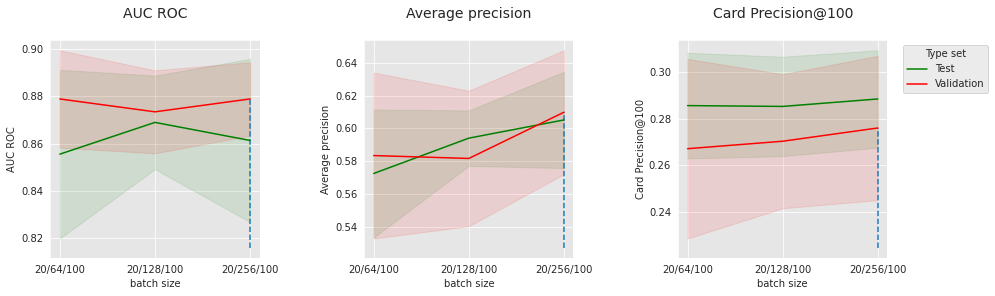

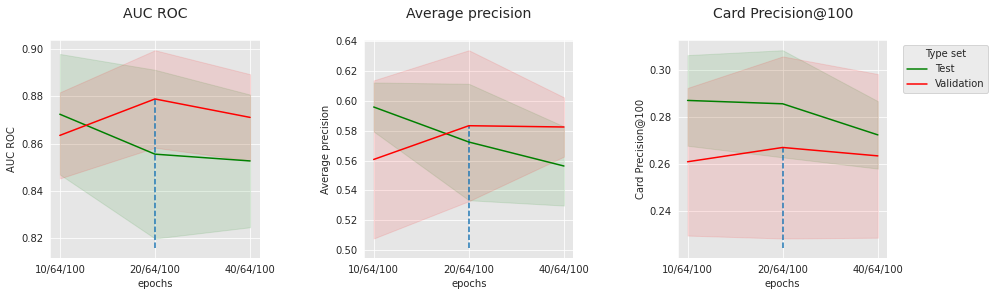

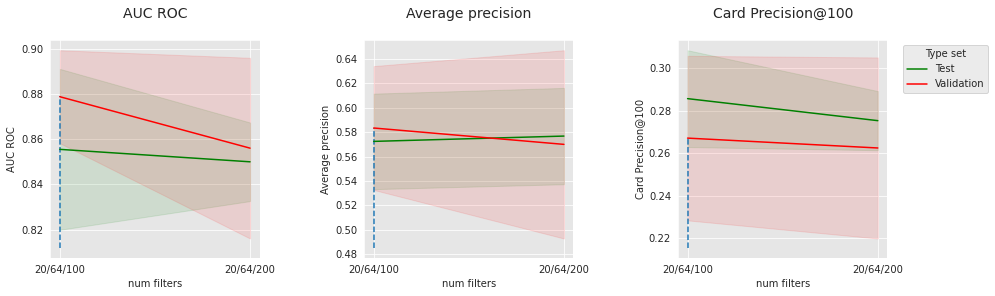

In [89]:
parameters_dict=dict(performances_df_cnn['Parameters'])
performances_df_cnn['Parameters summary']=[str(parameters_dict[i]['clf__max_epochs'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__batch_size'])+
                                   '/'+    
                                   str(parameters_dict[i]['clf__module__num_filters'])
                                   for i in range(len(parameters_dict))]

performances_df_cnn_subset = performances_df_cnn[performances_df_cnn['Parameters'].apply(lambda x:x['clf__lr']== 0.001 and x['clf__module__num_filters']==100 and x['clf__max_epochs']==20 and x['clf__module__num_conv']==2 and x['clf__module__p']==0.2).values]
summary_performances_cnn_subset=get_summary_performances(performances_df_cnn_subset, parameter_column_name="Parameters summary")
indexes_summary = summary_performances_cnn_subset.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_performances_cnn_subset.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(performances_df_cnn_subset, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="batch size",
                       summary_performances=summary_performances_cnn_subset)

performances_df_cnn_subset = performances_df_cnn[performances_df_cnn['Parameters'].apply(lambda x:x['clf__lr']== 0.001 and x['clf__module__num_filters']==100 and x['clf__batch_size']==64 and x['clf__module__num_conv']==2 and x['clf__module__p']==0.2).values]
summary_performances_cnn_subset=get_summary_performances(performances_df_cnn_subset, parameter_column_name="Parameters summary")
indexes_summary = summary_performances_cnn_subset.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_performances_cnn_subset.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(performances_df_cnn_subset, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="epochs",
                       summary_performances=summary_performances_cnn_subset)

performances_df_cnn_subset = performances_df_cnn[performances_df_cnn['Parameters'].apply(lambda x:x['clf__lr']== 0.001 and x['clf__max_epochs']==20 and x['clf__batch_size']==64 and x['clf__module__num_conv']==2 and x['clf__module__p']==0.2).values]
summary_performances_cnn_subset=get_summary_performances(performances_df_cnn_subset, parameter_column_name="Parameters summary")
indexes_summary = summary_performances_cnn_subset.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_performances_cnn_subset.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(performances_df_cnn_subset, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="num filters",
                       summary_performances=summary_performances_cnn_subset)


parameters_dict=dict(performances_df_cnn['Parameters'])
performances_df_cnn['Parameters summary']=[str(parameters_dict[i]['clf__max_epochs'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__num_conv'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__batch_size'])+
                                   '/'+    
                                   str(parameters_dict[i]['clf__module__num_filters'])+
                                   '/'+                                       
                                   str(parameters_dict[i]['clf__module__p'])
                                   for i in range(len(parameters_dict))]

Similar to the feed-forward network, the number of epochs and batch size, which are optimization parameters, have a sweet spot, which is probably connected to other parameters (model size, dropout, etc.). For the chosen optimization parameters, 100 filters seem to lead to better results than 200.

### Grid search on the Long Short Term Memory

For the LSTM, we will search the following hyperparameters:

* Batch size : [64,128,256]
* Initial learning rate: [0.0001, 0.0002, 0.001]
* Number of epochs : [5, 10, 20]
* Dropout rate : [0, 0.2, 0.4]
* Dimension of the LSTM hidden states : [100,200]

The LSTM takes sequences of transactions as input, so the process is the same as for the CNN, and the module also needs to be adapted to output two neurons. 

In [75]:
class FraudLSTM(torch.nn.Module):
    
    def __init__(self, num_features,hidden_size = 100, hidden_size_lstm = 100, num_layers_lstm = 1,p = 0):
        super(FraudLSTM, self).__init__()
        # parameters
        self.num_features = num_features
        self.hidden_size = hidden_size
        
        # representation learning part
        self.lstm = torch.nn.LSTM(self.num_features, hidden_size_lstm, num_layers_lstm, batch_first = True, dropout = p)
            
                    
        #representation to hidden
        self.fc1 = torch.nn.Linear(hidden_size_lstm, self.hidden_size)
        self.relu = torch.nn.ReLU()
        
        #hidden to output
        self.fc2 = torch.nn.Linear(self.hidden_size, 2)
        self.softmax = torch.nn.Softmax()
        
        self.dropout = torch.nn.Dropout(p)
        
    def forward(self, x):
        
        representation = self.lstm(x.transpose(1,2))

                    
        hidden = self.fc1(representation[1][0][0])
        relu = self.relu(hidden)
        relu = self.dropout(relu)
        
        output = self.fc2(relu)
        output = self.softmax(output)
        
        return output

In [76]:
seed_everything(42)
classifier = NeuralNetClassifier(
    FraudLSTM,
    max_epochs=2,
    lr=0.001,
    optimizer=torch.optim.Adam,
    batch_size=64,
    dataset=FraudSequenceDatasetForPipe,
    iterator_train__shuffle=True,
)
classifier.set_params(train_split=False, verbose=0)

parameters = {
    'clf__lr': [0.0001,0.0002,0.001],
    'clf__batch_size': [64,128,256],
    'clf__max_epochs': [5,10,20],
    'clf__module__hidden_size': [500],
    'clf__module__p': [0,0.2,0.4],
    'clf__module__num_features': [int(len(input_features))],
    'clf__module__hidden_size_lstm': [100,200],
}

start_time=time.time()

#these will get normalized but it should still work
input_features_new = input_features + ['CUSTOMER_ID','TX_DATETIME_TIMESTAMP']

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features_new, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=10)

execution_time_lstm = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__max_epochs'])+
                                   '/'+
                                    str(parameters_dict[i]['clf__batch_size'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__hidden_size_lstm'])+
                                   '/'+                           
                                   str(parameters_dict[i]['clf__module__p'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_lstm for model performance comparison at the end of this notebook
performances_df_lstm=performances_df

In [77]:
print(execution_time_lstm)

14750.79782986641


In [78]:
summary_performances_lstm=get_summary_performances(performances_df_lstm, parameter_column_name="Parameters summary")
summary_performances_lstm

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,5/256/100/0.2,20/128/100/0.4,5/64/200/0
Validation performance,0.881+/-0.01,0.681+/-0.01,0.286+/-0.02
Test performance,0.876+/-0.02,0.665+/-0.02,0.297+/-0.01
Optimal parameter(s),5/256/200/0.4,20/128/100/0.2,5/64/200/0.2
Optimal test performance,0.878+/-0.01,0.674+/-0.01,0.302+/-0.01


The results with the LSTM are more competitive than the CNN, and they are similar to the feed-forward network. This is still aligned with the hypothesis that the sequence does not really provide, for this dataset, a notable added value compared to only the last transaction with aggregated information. Nevertheless, the comparison with the CNN shows that, even with the same input, the choice of architecture can have an important impact on the performance. Moreover, the performed grid-search is for illustration purposes and is far from exhaustive, so the hyperparameters tuning brings an additional artifact to the results.

The conclusions about the set of optimal hyperparameters are very mixed here. Let us fix the learning rate to 0.0001, the batch size to 128, the dropout level to 0.2, and visualize the impact of the number of epochs and of the size of the hidden states.

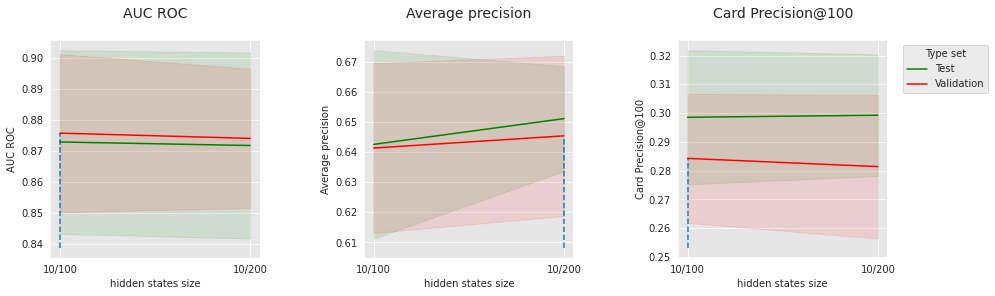

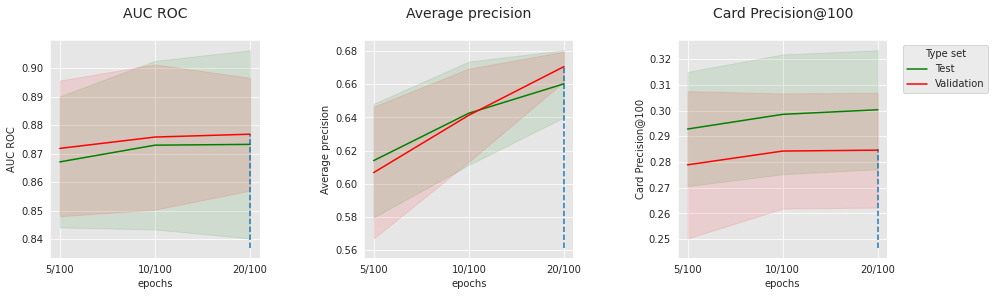

In [88]:
parameters_dict=dict(performances_df_lstm['Parameters'])
performances_df_lstm['Parameters summary']=[str(parameters_dict[i]['clf__max_epochs'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__hidden_size_lstm'])
                                   for i in range(len(parameters_dict))]

performances_df_lstm_subset = performances_df_lstm[performances_df_lstm['Parameters'].apply(lambda x:x['clf__lr']== 0.0001 and x['clf__batch_size']==128 and x['clf__max_epochs']==10 and x['clf__module__p']==0.2).values]
summary_performances_lstm_subset=get_summary_performances(performances_df_lstm_subset, parameter_column_name="Parameters summary")
indexes_summary = summary_performances_lstm_subset.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_performances_lstm_subset.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(performances_df_lstm_subset, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="hidden states size",
                       summary_performances=summary_performances_lstm_subset)

performances_df_lstm_subset = performances_df_lstm[performances_df_lstm['Parameters'].apply(lambda x:x['clf__lr']== 0.0001 and x['clf__batch_size']==128 and x['clf__module__hidden_size_lstm']==100 and x['clf__module__p']==0.2).values]
summary_performances_lstm_subset=get_summary_performances(performances_df_lstm_subset, parameter_column_name="Parameters summary")
indexes_summary = summary_performances_lstm_subset.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_performances_lstm_subset.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(performances_df_lstm_subset, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="epochs",
                       summary_performances=summary_performances_lstm_subset)

parameters_dict=dict(performances_df_lstm['Parameters'])
performances_df_lstm['Parameters summary']=[str(parameters_dict[i]['clf__max_epochs'])+
                                   '/'+
                                    str(parameters_dict[i]['clf__batch_size'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__hidden_size_lstm'])+
                                   '/'+                           
                                   str(parameters_dict[i]['clf__module__p'])
                                   for i in range(len(parameters_dict))]

Recall here that the grid search is not exhaustive, and from the plots, it appears that the average precision could have been further improved.

### Grid search on the LSTM with Attention

For the LSTM with Attention, we apply the exact same process as for the LSTM.

In [79]:
class FraudLSTMWithAttention(torch.nn.Module):
    
    def __init__(self, num_features,hidden_size = 100, hidden_size_lstm = 100, num_layers_lstm = 1,p = 0):
        super(FraudLSTMWithAttention, self).__init__()
        # parameters
        self.num_features = num_features
        self.hidden_size = hidden_size
        
        # representation learning part
        self.lstm = torch.nn.LSTM(self.num_features, hidden_size_lstm, num_layers_lstm, batch_first = True, dropout = p)
            
        # last sequence represenation
        self.ff = torch.nn.Linear(self.num_features,hidden_size_lstm)
        
        attention_out_dim = hidden_size_lstm
        
        # attention layer
        self.attention = Attention(attention_out_dim)                        
       
        #representation to hidden
        self.fc1 = torch.nn.Linear(hidden_size_lstm, self.hidden_size)
        self.relu = torch.nn.ReLU()
        
        #hidden to output
        self.fc2 = torch.nn.Linear(self.hidden_size, 2)
        self.softmax = torch.nn.Softmax()
        
        self.dropout = torch.nn.Dropout(p)
        
    def forward(self, x):
        
        representation_seq, _ = self.lstm(x.transpose(1,2))
        
        representation_last = self.ff(x[:,:,-1:].transpose(1,2))
        
        representation, attn = self.attention(representation_last,representation_seq)

                    
        hidden = self.fc1(representation[:,0,:])
        relu = self.relu(hidden)
        relu = self.dropout(relu)
        
        output = self.fc2(relu)
        output = self.softmax(output)
        
        return output

In [80]:
seed_everything(42)
classifier = NeuralNetClassifier(
    FraudLSTMWithAttention,
    max_epochs=2,
    lr=0.001,
    optimizer=torch.optim.Adam,
    batch_size=64,
    dataset=FraudSequenceDatasetForPipe,
    iterator_train__shuffle=True,
)
classifier.set_params(train_split=False, verbose=0)

parameters = {
    'clf__lr': [0.0001,0.0002,0.001],
    'clf__batch_size': [64,128,256],
    'clf__max_epochs': [5,10,20],
    'clf__module__hidden_size': [500],
    'clf__module__p': [0,0.2,0.4],
    'clf__module__num_features': [int(len(input_features))],
    'clf__module__hidden_size_lstm': [100,200],
}

start_time=time.time()

#these will get normalized but it should still work
input_features_new = input_features + ['CUSTOMER_ID','TX_DATETIME_TIMESTAMP']

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features_new, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=10)

execution_time_lstm_attn = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__max_epochs'])+
                                   '/'+
                                    str(parameters_dict[i]['clf__batch_size'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__hidden_size_lstm'])+
                                   '/'+                           
                                   str(parameters_dict[i]['clf__module__p'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_lstm for model performance comparison at the end of this notebook
performances_df_lstm_attn=performances_df

In [81]:
print(execution_time_lstm_attn)

16735.779472112656


In [82]:
summary_performances_lstm_attn=get_summary_performances(performances_df_lstm_attn, parameter_column_name="Parameters summary")
summary_performances_lstm_attn

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,10/64/100/0.2,10/64/200/0.2,20/256/200/0.2
Validation performance,0.886+/-0.02,0.69+/-0.01,0.287+/-0.02
Test performance,0.874+/-0.02,0.667+/-0.01,0.295+/-0.01
Optimal parameter(s),5/256/200/0.4,10/64/200/0,10/64/200/0
Optimal test performance,0.879+/-0.02,0.676+/-0.02,0.303+/-0.01


The LSTM with Attention has a performance that is only slightly better than the regular LSTM. Although Attention is a mechanism that significantly impacts many applications such as NLP, its interest can be limited on such sequences that are rather short and on such a model that only has a single recurrent layer.

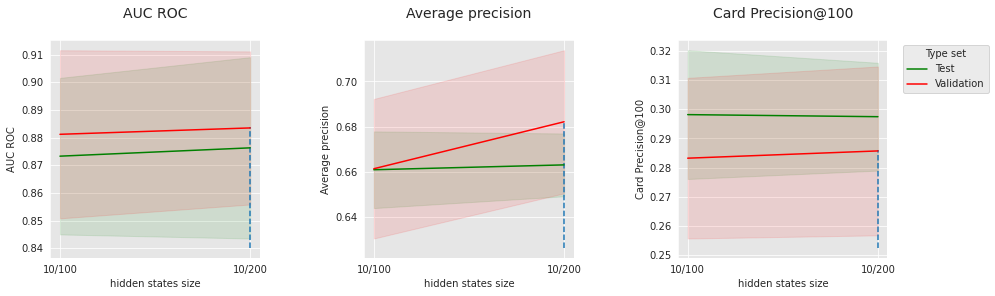

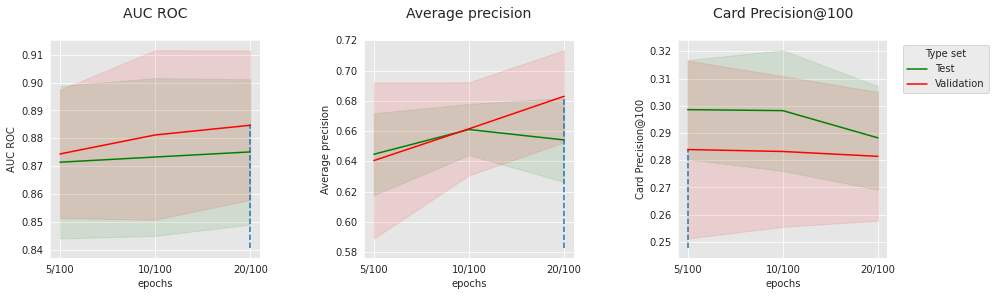

In [90]:
parameters_dict=dict(performances_df_lstm_attn['Parameters'])
performances_df_lstm_attn['Parameters summary']=[str(parameters_dict[i]['clf__max_epochs'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__hidden_size_lstm'])
                                   for i in range(len(parameters_dict))]

performances_df_lstm_attn_subset = performances_df_lstm_attn[performances_df_lstm_attn['Parameters'].apply(lambda x:x['clf__lr']== 0.0001 and x['clf__batch_size']==128 and x['clf__max_epochs']==10 and x['clf__module__p']==0.2).values]
summary_performances_lstm_attn_subset=get_summary_performances(performances_df_lstm_attn_subset, parameter_column_name="Parameters summary")
indexes_summary = summary_performances_lstm_attn_subset.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_performances_lstm_attn_subset.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(performances_df_lstm_attn_subset, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="hidden states size",
                       summary_performances=summary_performances_lstm_attn_subset)

performances_df_lstm_attn_subset = performances_df_lstm_attn[performances_df_lstm_attn['Parameters'].apply(lambda x:x['clf__lr']== 0.0001 and x['clf__batch_size']==128 and x['clf__module__hidden_size_lstm']==100 and x['clf__module__p']==0.2).values]
summary_performances_lstm_attn_subset=get_summary_performances(performances_df_lstm_attn_subset, parameter_column_name="Parameters summary")
indexes_summary = summary_performances_lstm_attn_subset.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_performances_lstm_attn_subset.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(performances_df_lstm_attn_subset, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="epochs",
                       summary_performances=summary_performances_lstm_attn_subset)

parameters_dict=dict(performances_df_lstm_attn['Parameters'])
performances_df_lstm_attn['Parameters summary']=[str(parameters_dict[i]['clf__max_epochs'])+
                                   '/'+
                                    str(parameters_dict[i]['clf__batch_size'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__hidden_size_lstm'])+
                                   '/'+                           
                                   str(parameters_dict[i]['clf__module__p'])
                                   for i in range(len(parameters_dict))]

For the same set of hyperparameters, the convergence w.r.t the average precision is different than LSTM without Attention.


## Saving of results

Let us save the performance results and execution times of these three models in a Python pickle format.

In [83]:
performances_df_dictionary={
    "CNN": performances_df_cnn,    
    "LSTM": performances_df_lstm,    
    "LSTM_Attention": performances_df_lstm_attn,
}

execution_times=[execution_time_cnn,execution_time_lstm,execution_time_lstm_attn]

filehandler = open('performances_model_selection_seq_model.pkl', 'wb') 
pickle.dump((performances_df_dictionary, execution_times), filehandler)
filehandler.close()

## Benchmark summary

Let us finally retrieve the performance results obtained in

* [Chapter 5](Model_Selection_Comparison_Performances) with decision tree, logistic regression, random forest and XGBoost, and
* [Chapter 7, Section 2](Model_Selection_FFNN) with feed-forward neural networks

and compare them with those obtained with CNN, LSTM, and LSTM with Attention. 

The results can be retrieved by loading the `performances_model_selection.pkl`, `performances_model_selection_nn.pkl` and `performances_model_selection_seq_model.pkl` pickle files, and summarized with the `get_summary_performances` function.

In [2]:
# Load performance results for decision tree, logistic regression, random forest and XGBoost
filehandler = open('../Chapter_5_ModelValidationAndSelection/performances_model_selection.pkl', 'rb') 
(performances_df_dictionary, execution_times) = pickle.load(filehandler)

# Load performance results for feed-forward neural network
filehandler = open('performances_model_selection_nn.pkl', 'rb') 
(performances_df_dictionary_nn, execution_times_nn) = pickle.load(filehandler)

# Load performance results for CNN, LSTM and LSTM with Attention
filehandler = open('performances_model_selection_seq_model.pkl', 'rb') 
(performances_df_dictionary_seq_model, execution_times_seq_model) = pickle.load(filehandler)


In [9]:
performances_df_dt=performances_df_dictionary['Decision Tree']
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")

performances_df_lr=performances_df_dictionary['Logistic Regression']
summary_performances_lr=get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")

performances_df_rf=performances_df_dictionary['Random Forest']
summary_performances_rf=get_summary_performances(performances_df_rf, parameter_column_name="Parameters summary")

performances_df_xgboost=performances_df_dictionary['XGBoost']
summary_performances_xgboost=get_summary_performances(performances_df_xgboost, parameter_column_name="Parameters summary")

performances_df_nn=performances_df_dictionary_nn['Neural Network']
summary_performances_nn=get_summary_performances(performances_df_nn, parameter_column_name="Parameters summary")

performances_df_cnn=performances_df_dictionary_seq_model['CNN']
summary_performances_cnn=get_summary_performances(performances_df_cnn, parameter_column_name="Parameters summary")

performances_df_lstm=performances_df_dictionary_seq_model['LSTM']
summary_performances_lstm=get_summary_performances(performances_df_lstm, parameter_column_name="Parameters summary")

performances_df_lstm_attention=performances_df_dictionary_seq_model['LSTM_Attention']
summary_performances_lstm_attention=get_summary_performances(performances_df_lstm_attention, parameter_column_name="Parameters summary")

summary_test_performances = pd.concat([summary_performances_dt.iloc[2,:],
                                       summary_performances_lr.iloc[2,:],
                                       summary_performances_rf.iloc[2,:],
                                       summary_performances_xgboost.iloc[2,:],
                                       summary_performances_nn.iloc[2,:],
                                       summary_performances_cnn.iloc[2,:],
                                       summary_performances_lstm.iloc[2,:],
                                       summary_performances_lstm_attention.iloc[2,:],
                                      ],axis=1)
summary_test_performances.columns=['Decision Tree', 'Logistic Regression', 'Random Forest', 'XGBoost', 
                                   'Neural Network', 'CNN', 'LSTM', 'LSTM with Attention']


The results are summarized in a `summary_test_performances` table. Rows provide the average performance results on the test sets in terms of AUC ROC, Average Precision and CP@100. 

In [10]:
summary_test_performances

,Decision Tree,Logistic Regression,Random Forest,XGBoost,Neural Network,CNN,LSTM,LSTM with Attention
AUC ROC,0.797+/-0.01,0.868+/-0.02,0.87+/-0.02,0.869+/-0.01,0.876+/-0.01,0.872+/-0.01,0.876+/-0.02,0.874+/-0.02
Average precision,0.579+/-0.01,0.623+/-0.02,0.678+/-0.01,0.687+/-0.01,0.675+/-0.01,0.599+/-0.01,0.665+/-0.02,0.667+/-0.01
Card Precision@100,0.284+/-0.0,0.297+/-0.01,0.299+/-0.01,0.303+/-0.01,0.303+/-0.02,0.288+/-0.01,0.297+/-0.01,0.295+/-0.01


In the end, it appears that neural-network based approaches provide results that are competitive with random forests and XGBoost, providing slightly better performances in terms of AUC ROC, and slightly worse performances in terms of Average Precision. However, it should be kept in mind that, given more computational resources, a more extensive hyperparameter tuning could be performed for neural network-based approaches that would likely lead to further improve their performances. 


## Conclusion

In this section, automatic methods to build features from contextual data were explored. To classify a transaction as fraudulent or genuine, it is generally useful to resort to the regular behavior of the cardholder in order to detect a discrepancy. A manual method to integrate this contextual information is to proceed with feature engineering and the creation of expert feature aggregations. 

Automatic representation learning methods from the Deep Learning literature have been explored to create features that represent the cardholder's sequence of previous transactions in a way that optimizes the classification of the current transaction. 

The key methodological components are the building of the data pipeline to automatically create the sequential data from landmark variables and the right combination of adapted neural networks such as the 1D-CNN, the LSTM, the Attention mechanism, etc. These models have been tested here, and they can provide competitive performance. In the future, other candidate architectures such as Multi-Head Self-Attention, Sequence-to-Sequence Autoencoder, or any combination of the above modules could be explored to attempt to further improve fraud detection performance. 